# Political stance classification using pretrained-BERT

This notebook is a code for training a neural network which classify political orientation of the given text.

It requires install [pretrained transformer](https://pypi.org/project/transformers/) package.


In [ ]:
!pip install transformers --quiet
!pip install scikit-plot

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

# For the setup model
import torch
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel

# For the training
from torch.optim import Adam
from tqdm import tqdm

# For the confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt



Before executing this notebook, please modify below paths for your own setup.

In [7]:
path_for_saving_model = './sample_data/'
path_for_opening_data = './'

This neural network model has labels for the classifier; 0 for left, 1 for center, and 2 for right. We made a Dataset class, which is inherited from [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html) and having new attributes called 'label' and 'texts'. Both attributes are lists, but 'label' stores the list of the political stance of articles, while 'texts' store the list of the article itself. 


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'left':0,
          'center':1,
          'right':2,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['relative_stance']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

We construct a neural network with 4 layers as follow.



```
# (1,512) -> (BERT Layer)-> (1,768) -> (Dropout) -> (1,768) -> Linear -> (1,3) -> ReLu (1,3)
```

The classification was judged by the maximum among all 3 outputs. For example, the output (0.1,2.32,4.57) from an article is considered to be right.

In [9]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

We train this model using 16 batches. The loss function for this model is cross entropy, but may other loss functions could be chosen in future. Also, to avoid possible crash, we saved the model after each epoch as

```
(path_for_saving_model)/model_bert(epoch_num).pkl
```
using [pickle](https://docs.python.org/3/library/pickle.html).



In [10]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            # Save the model after 1 epoch.
            with open(path_for_saving_model+'model_bert'+str(epoch_num)+'.pkl', 'wb') as file:
              pickle.dump(model, file)
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')


Now set up hyper parameters. EPOCHS determine how many trains will be done. LR determines the learning rate of the neural network model, used by the pytorch optimizer [adam](https://pytorch.org/docs/stable/optim.html).

In [11]:
EPOCHS = 5
LR = 1e-6

Now, load the data. You can get the original data below via [this link](https://drive.google.com/drive/folders/1HVmXj-dzE0WfLxuOiT4dCcuKpd7ujOOo?usp=sharing). Please put these csv files on your '''path_for_opening_data''' folder. In this notebook, the result was based on the [dummy files](https://github.com/PolarisNMA2022/PoliticalStanceClassification/tree/main/dummy_data). 

Dummy files consisting of 14386 articles in the traning set, 1893 articles in the validation set, and 1768 articles in the test set.

In [13]:
# Load Data set.
df_train = pd.read_csv(path_for_opening_data+"BIGNEWS_cleaned_train_204000.csv",index_col=0)
df_test = pd.read_csv(path_for_opening_data+"BIGNEWS_cleaned_test_25500.csv",index_col=0)
df_val = pd.read_csv(path_for_opening_data+"BIGNEWS_cleaned_val_25500.csv",index_col=0)

If you are ready, then set up the model and train it.

**Warning** If you use the original data for the training with GPU (cuda), it takes 1 hour for tokenizing data from the train and validation set, and 3 hours for each epoch, with using 15GB of the RAM (in Kaggle or Colab). Even if you use dummy files, it take an hour for 5 epochs.

In [14]:
model = BertClassifier()
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 878/878 [11:43<00:00,  1.25it/s]


Epochs: 1 | Train Loss:  0.069                 | Train Accuracy:  0.331                 | Val Loss:  0.069                 | Val Accuracy:  0.330


100%|██████████| 878/878 [11:40<00:00,  1.25it/s]


Epochs: 2 | Train Loss:  0.066                 | Train Accuracy:  0.423                 | Val Loss:  0.063                 | Val Accuracy:  0.500


100%|██████████| 878/878 [11:40<00:00,  1.25it/s]


Epochs: 3 | Train Loss:  0.060                 | Train Accuracy:  0.548                 | Val Loss:  0.059                 | Val Accuracy:  0.565


100%|██████████| 878/878 [11:39<00:00,  1.25it/s]


Epochs: 4 | Train Loss:  0.052                 | Train Accuracy:  0.650                 | Val Loss:  0.051                 | Val Accuracy:  0.660


100%|██████████| 878/878 [11:39<00:00,  1.25it/s]


Epochs: 5 | Train Loss:  0.045                 | Train Accuracy:  0.709                 | Val Loss:  0.047                 | Val Accuracy:  0.685


Lastly, you can chcek the test accuracy and confusion matrix using the below code. If you use the original data with 5 epochs, then it has a result below.

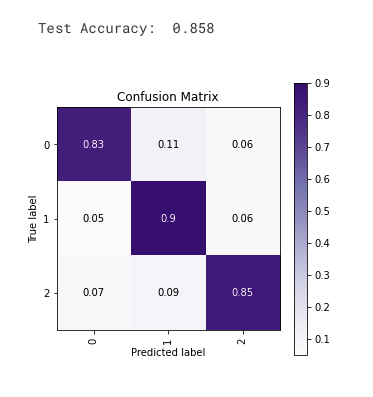

Test Accuracy:  0.679


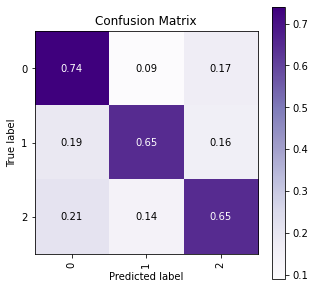

In [15]:
get_output=[]
get_testlabels=[]

def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            get_testlabels.append(test_label)
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            get_output.append(output.argmax(dim=1))
            total_acc_test += acc
        print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
evaluate(model, df_test)

model_y = [item.cpu().detach().numpy().tolist() for item in get_output]
test_y = [item.cpu().detach().numpy().tolist() for item in get_testlabels]
model_y = [x for xs in model_y for x in xs]
test_y = [x for xs in test_y for x in xs]

target_classes = [0, 1, 2]
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in test_y], [target_classes[i] for i in model_y],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);